In [2]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#Read in the data. From Quandl
df = pd.read_csv('EOD-BA.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2017-12-28,295.810,296.9900,294.7400,296.35,1436543.0,0.0,1.0,283.539280,284.670331,282.513665,284.056879,1436543.0
1,2017-12-27,296.410,296.8000,294.8000,295.62,1447837.0,0.0,1.0,284.114391,284.488213,282.571176,283.357161,1447837.0
2,2017-12-26,295.540,297.4400,294.6500,295.36,1394737.0,0.0,1.0,283.280480,285.101664,282.427398,283.107946,1394737.0
3,2017-12-22,295.135,296.5200,293.0100,295.10,2257000.0,0.0,1.0,282.892280,284.219828,280.855429,282.858732,2257000.0
4,2017-12-21,298.040,298.3852,294.1301,295.03,5395193.0,0.0,1.0,285.676775,286.007656,281.929065,282.791635,5395193.0


# Explaining the Data
This is the Stock Prices, Dividends and Splits of the Boeing Company (BA) from the dates 09/02/2013 - 12/28/2017. Open is the starting price for the stock on a given day.
High and Low are the Maximum and Minimum that the price of a stock reached that day. 
Close is the final price for the stock on a given day.
Volume is the number of shares bought throughout the day.
# Goal
The Goal is to calculate the closing price given the Open, High, Low, and Volume of the stock on the given day. This will allow to compute the profit or loss of the stock before the day ends. This will be done using a technical analysis of the stock. Which is using statistical data to identify trends on the company's stock. 
### The History of the Closing Price of Boeing Stock

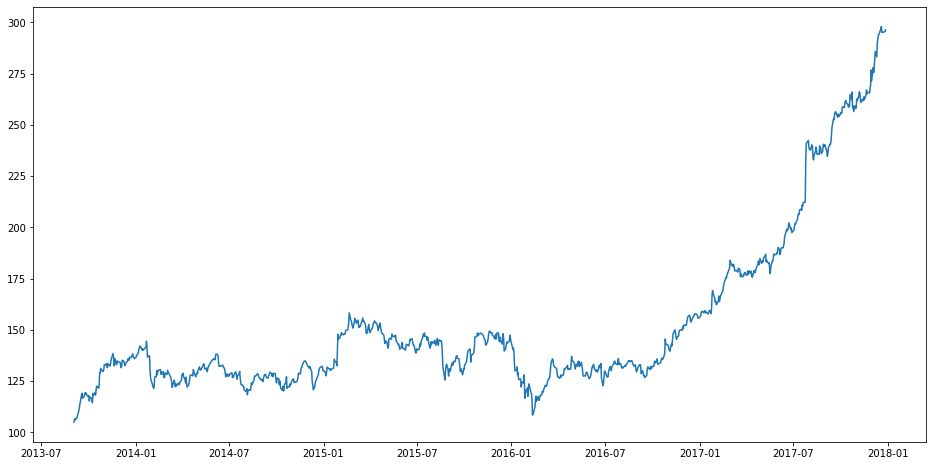

In [4]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date'] #setting X-axis as date
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

# Long Short Term Memory (LSTM)
From the Goal section it is explained that prediction will be done by performing a techinical analysis of the company's stock. This is the structure of a sequence prediction problem. LSTMs are used for sequence prediction problems because they are extemely effective. The reason they are so effective is because LSTM is able to store past information that is important and forget information that is not. 
### The input gate: The input gate adds information to the cell state
### The forget gate: It removes the information that is no longer required by the model
### The output gate: Selects the information to be shown as output

In [8]:
#Creating a dataframe for manipulation and analysis
data = df.sort_index(ascending=True, axis=0)
dataFrame = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    dataFrame['Date'][i] = data['Date'][i]
    dataFrame['Close'][i] = data['Close'][i]
dataFrame.index = dataFrame.Date
dataFrame.drop('Date', axis=1, inplace=True)

#Creating train and test sets using the dataFrame. Splitting 80% train & 20% test
dataSet = dataFrame.values
train = dataSet[0:857,:]
test = dataSet[857:,:]

#Splitting the dataSet into given variables and variables to solve for
scaler = MinMaxScaler(feature_range=(0, 1))
scaledData = scaler.fit_transform(dataSet)
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaledData[i-60:i,0])
    y_train.append(scaledData[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Creating the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1))) #Input 
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting values, using past 60 from the train data
inputs = dataFrame[len(dataFrame) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
x_test = []
for i in range(60,inputs.shape[0]): #Forget
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
closingPrice = model.predict(x_test) #Output
closingPrice = scaler.inverse_transform(closingPrice)

Epoch 1/1
 - 127s - loss: 6.8348e-04


# Adam as an Optimizer
Stands for Adaptive Moment Estimation. It computes individual learning rates for each different parameter. Adam uses estimations of the first and second moments of the gradient to adapt the learning rate for each weight of the neural network. 

In [9]:
Error=np.sqrt(np.mean(np.power((test-closingPrice),2)))
Error

9.244582061139386

C:\Users\ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


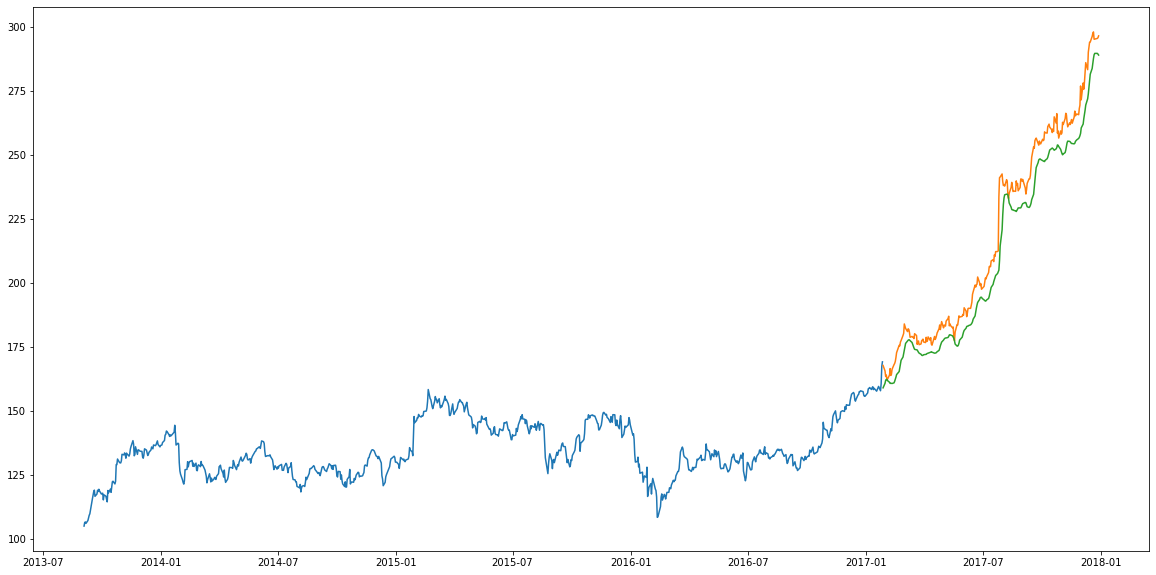

In [10]:
#for plotting
train = dataFrame[:857]
test = dataFrame[857:]
test['Predictions'] = closingPrice
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])

# Results
The Green line is the actual value where as the orange line is the calculated value. So the use of a LSTM algorithm was extremely effective at predicting the next day's closing price. With only a loss of 6.83e-4 this is close to perfect. This is expexted because the LSTM can forget the information that is useless and can build upon the information that is usefull.